### World Models Coding Exercise 1: Spatial Learning with Discrete Diffusion

In this coding exercise we will be using a neural network to learn a world model of simple discrete environments. We will explore how to train our model using diffusion techniques, which means even with noisy inputs it can generate observations it has seen before and is robust against noise.

To get started let's check out our world, which is 3x3 grid of cells, and each cell is also 3x3 of mini-cells but only ever 3 mini-cells at a time are active. To see what this looks like, run the cell below.

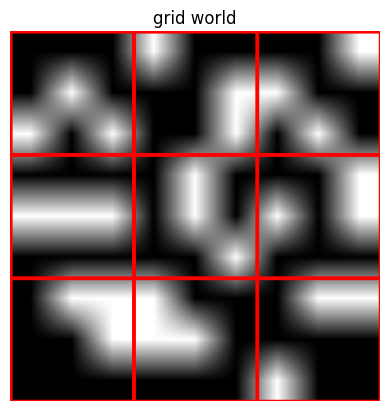

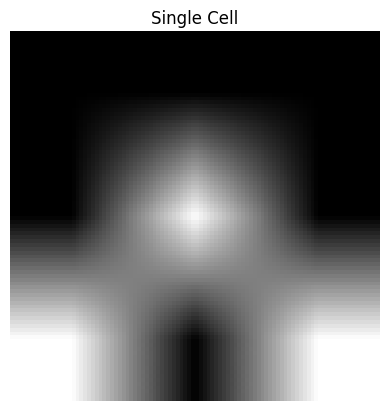

grid world is tensor([78, 24, 52, 64, 42, 50, 30, 13, 31])


In [36]:
import itertools
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# ----------------------- utilities -----------------------------------------
PATTERNS, IDX = [], {}
for combo in itertools.combinations(range(9), 3):
    v = torch.zeros(9, dtype=torch.long)
    v[list(combo)] = 1
    IDX[tuple(v.tolist())] = len(PATTERNS)
    PATTERNS.append(v)

def pt(mat):
    return IDX[tuple([e for row in mat for e in row])]

def patch(i):
    return PATTERNS[i].view(3, 3)

def to_img(tokens, zoom=32):
    patches = [patch(int(t)) for t in tokens]
    rows = [torch.cat(patches[r*3:(r+1)*3], 1) for r in range(3)]
    raw = torch.cat(rows, 0).numpy().astype(np.uint8)
    grid = raw * 255
    img = cv2.resize(grid, (grid.shape[1]*zoom, grid.shape[0]*zoom), cv2.INTER_NEAREST)
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    
    # Draw red borders around the 3x3 cells
    cell_size = zoom * 3
    for i in range(3):
        for j in range(3):
            top_left = (j * cell_size, i * cell_size)
            bottom_right = ((j + 1) * cell_size, (i + 1) * cell_size)
            cv2.rectangle(img, top_left, bottom_right, (0, 0, 255), 2)  # Red color, thickness 2
    
    return img

def single_patch_img(token, zoom=32):
    patch_img = patch(int(token)).numpy().astype(np.uint8) * 255
    img = cv2.resize(patch_img, (patch_img.shape[1]*zoom, patch_img.shape[0]*zoom), cv2.INTER_NEAREST)
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)

world = torch.randint(0, 84, (9,))

# Visualize the entire grid
vis = to_img(world)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('grid world')
plt.axis('off')  # Hide axes
plt.show()

# Visualize a single cell (e.g., the first cell)
single_cell_img = single_patch_img(world[0])
plt.imshow(cv2.cvtColor(single_cell_img, cv2.COLOR_BGR2RGB))
plt.title('Single Cell')
plt.axis('off')  # Hide axes
plt.show()

print(f'grid world is {world}')

Here we see the grid world as 3x3 cells with a red boarder seperating the cells.Then zoom in on a single cell at the top left of the grid. Since each cell is 3 active pixels out of 9 it has (9 chose 3) = 84 different possibilites.

The formula for combinations is given by:

$$
\binom{9}{3} = \frac{9!}{3!(9-3)!} = 84
$$

This means each cell can be represented as a number between {0,83} and with 9 cells this looks like a vector of 9 numbers each between {0,83}. Check out the grid world tensor printout above. 

This mapping makes the world discrete with categorigical distributions out of 84 possible states for each cell. With 84 possible states we can still create a variety of expressive interesting worlds and at the same time keep it manageable for a world model to learn.

Next lets introduce the world model and learn observations from the world. 



Let's start with a simple world model that just processes space, run the cell below and check it out.

In [42]:
from rotary_embedding_torch import RotaryEmbedding
from attention import SpatialAxialAttention

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # hidden dimension and attention heads
        self.d = 128
        heads = 4
        self.dim_head = self.d // heads

        # token embedding + 1D positional encoding
        self.emb = nn.Embedding(84, self.d)
        self.pos = nn.Parameter(torch.zeros(9, self.d))
        nn.init.trunc_normal_(self.pos, std=0.02)

        # rotary embeddings for a 3×3 grid axial attention
        # use half the head dim so that 2D axial rotary (2 axes) fits into head_dim
        self.spatial_rotary_emb = RotaryEmbedding(
            dim=self.dim_head // 2,
            freqs_for="pixel",
            max_freq=256
        )

        # single Spatial Axial Attention block expects a T dimension
        self.spatial = SpatialAxialAttention(
            dim=self.d,
            heads=heads,
            dim_head=self.dim_head,
            rotary_emb=self.spatial_rotary_emb,
        )

        # output head projects back to token logits
        self.head = nn.Linear(self.d, 84)

    def forward(self, x: torch.LongTensor) -> torch.Tensor:
        """
        x: shape (B, 9) LongTensor of token indices
        returns: (B, 9, 84) logits for each of the 84 tokens per position
        """
        B, N = x.shape
        # embed tokens + add 1D positional embedding
        tok = self.emb(x) + self.pos        # (B, 9, d)

        # reshape into 2D grid and add a time/frame dim of 1
        tok2d = tok.view(B, 3, 3, self.d)   # (B, H=3, W=3, d)
        tok3d = tok2d.unsqueeze(1)         # (B, T=1, H, W, d)

        # apply spatial axial attention
        out3d = self.spatial(tok3d)        # (B, 1, 3, 3, d)

        # collapse T back to singleton for sequence
        out2d = out3d.squeeze(1)           # (B, 3, 3, d)

        # back to sequence of length 9
        out1d = out2d.reshape(B, N, self.d)   # (B, 9, d)

        # final projection to logits
        return self.head(out1d)            # (B, 9, 84)

dev=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m=Model().to(dev)

world = torch.randint(0, 84, (9,)).unsqueeze(0).to(dev)
print(f'{world} world shape is {world.shape}')
logits = m(world)  
print(f'logits shape is {logits.shape}')
print(f'inspect the first cell probs {logits[0][0]}')


tensor([[65, 82, 52, 33, 12, 44, 81, 10, 44]], device='cuda:0') world shape is torch.Size([1, 9])
logits shape is torch.Size([1, 9, 84])
inspect the first cell probs tensor([ 0.0612, -0.1494,  0.1356, -0.0318,  0.0132,  0.1130, -0.0558, -0.1107,
        -0.0054,  0.0591,  0.0672, -0.0537,  0.0048, -0.0327, -0.0747,  0.0223,
         0.0111, -0.0087, -0.0626, -0.0949,  0.0536,  0.2183, -0.0550, -0.0094,
         0.2072,  0.0267, -0.0550,  0.0538,  0.0998,  0.0145, -0.0964, -0.0690,
        -0.1469, -0.0239,  0.1960, -0.0332, -0.1765, -0.0030, -0.0316,  0.0449,
        -0.0618,  0.1776,  0.0921, -0.0339, -0.0688,  0.1487, -0.0693, -0.1042,
         0.0259,  0.1321, -0.0860,  0.0816, -0.0176, -0.1765, -0.0641,  0.0237,
         0.0037, -0.0166,  0.0075, -0.0922, -0.0974, -0.0669, -0.0478,  0.1311,
        -0.0166,  0.1399, -0.0153, -0.1488,  0.2121, -0.0324, -0.1400,  0.0473,
        -0.0589,  0.0336, -0.0855,  0.0190, -0.0045,  0.0889, -0.0215,  0.0194,
         0.1835,  0.0518,  0.0874,

After running the cell we see the world model take in a grid world state which is a single batch of 9 cells giving a shape [1,9]. The world model then outputs logits which are the probabilities of each possible state for each cell for that single batch. Since there are 9 cells each with 84 possible states this gives a shape of [1,9,84] we also print out the probabilities for the first cell, the higher the value the more probable it is.

Let's put those logits to use and learn how to train the world model to learn a single observation from the world. We will train the model using diffusion, so the model will learn to associate noisy world observations to clean world obervations. The amount of noise for the input observations will randomly vary it could be very slight or very extreme. With a high variety of different noise level the model learns to ignore the noise and focus on the most consistent elements of the world observations, then being able to recreate the world.

Next, let's look at the function that adds noise to our world's observation. Run the cell below to see how it works.


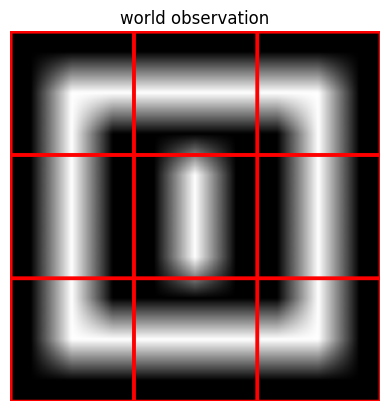

noise levels per cell tensor([0.7262, 0.7011, 0.2038, 0.6511, 0.7745, 0.4369, 0.5191, 0.6159, 0.8102])


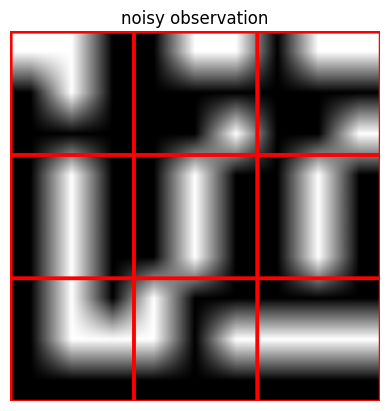

In [93]:
def noisy_sample(target, verbose=False):
    e = torch.rand(9)                # entropy per position   ∈ [0,1]
    base = (e / 84).unsqueeze(1).repeat(1, 84)   # prob for any incorrect token
    probs = base.clone()
    rows  = torch.arange(9)
    probs[rows, target] = 1.0 - e * 83 / 84       # correct-token prob
    samples = torch.multinomial(probs, 1).squeeze(1)
    if verbose:
        return samples, e
    else:
        return samples
    
# ----------------------- observation --------------------------------------------
corner_TL=pt([[0,0,0],[0,1,1],[0,1,0]])
corner_TR=pt([[0,0,0],[1,1,0],[0,1,0]])
corner_BL=pt([[0,1,0],[0,1,1],[0,0,0]])
corner_BR=pt([[0,1,0],[1,1,0],[0,0,0]])
vertical =pt([[0,1,0],[0,1,0],[0,1,0]])
horizontal=pt([[0,0,0],[1,1,1],[0,0,0]])

observation=torch.tensor([
    corner_TL,horizontal,corner_TR,
    vertical,vertical,vertical,
    corner_BL,horizontal,corner_BR],dtype=torch.long)

# Visualize the world observation
vis = to_img(observation)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('world observation')
plt.axis('off')  # Hide axes
plt.show()

noisy_obs, noise_levels = noisy_sample(observation, verbose=True)

print(f'noise levels per cell {noise_levels}')

# Visualize the noisy observation
vis = to_img(noisy_obs)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('noisy observation')
plt.axis('off')  # Hide axes
plt.show()


When generating a noisy observation, a random noise level is assigned to each cell. The noise level defines the probability that any of the possible 84 cells are chosen. If the noise level is 0.0, then there is 100% probability that the actual observed cell is sampled, while a noise level of 1.0 means there is an equal probability of any cell being sampled. So noise level controls the entropy of the sampled cell: 0.0 means no entropy and max certainty, while 1.0 means max entropy and no certainty. Run the code below with the interactive noise level slider to see how the probability shifts for selecting the actual observed cell (<span style="color:red">RED</span>) vs all other cells (<span style="color:blue">BLUE</span>).

In [99]:
from ipywidgets import interact, FloatSlider

# Define the function to update the histogram based on the slider value
def update_histogram(e_value):
    target = torch.randint(0, 84, (9,))
    e = torch.full((9,), e_value)
    base = (e / 84).unsqueeze(1).repeat(1, 84)   # prob for any incorrect token
    probs = base.clone()
    rows = torch.arange(9)
    probs[rows, target] = 1.0 - e * 83 / 84       # correct-token prob
    
    # Plot histogram of probabilities for the first cell
    plt.figure(figsize=(10, 6))
    bar_colors = ['blue'] * 84
    bar_colors[target[0].item()] = 'red'  # Highlight the observed cell in red
    plt.bar(np.arange(84), probs[0].numpy(), color=bar_colors, alpha=0.7)
    plt.title(f'Histogram of Cell Probabilities (noise level = {e_value:.2f})')
    plt.xlabel('Cells')
    plt.ylabel('Probability')
    plt.show()

# Create a slider widget
slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.9, description='Entropy (e)')

# Use interact to link the slider to the update_histogram function
interact(update_histogram, e_value=slider)

interactive(children=(FloatSlider(value=0.9, description='Entropy (e)', max=1.0, step=0.01), Output()), _dom_c…

<function __main__.update_histogram(e_value)>

Now that we can add a defined noise to the world's observations, let's train the world model using it, so that afterwards no matter what starting state it can recreate the observations it saw from the world.

Run the below cell to re-initialize the model and its optimizer that takes the model's weights to train it from its loss.

The second cell below then runs the training loop.

In [129]:
# Reset the model and its optimizer
m=Model().to(dev)
opt = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [128]:
# Run Training Loop
from ipywidgets import IntSlider, Button, VBox, Output
from IPython.display import display, clear_output
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

def run(max_steps=500, seed=0):
    torch.manual_seed(seed)
    
    tokens = torch.randint(0, 84, (1, 9), device=dev)
    # if you ever want to reassign m, declare it nonlocal too
    learning = True
    generate = True

    step_slider = IntSlider(min=1, max=max_steps, step=1, value=1, description='Step')
    button1 = Button(description='Run')
    button2 = Button(description='Reset State')
    out = Output()

    def update(step):
        nonlocal tokens
        with out:
            clear_output(wait=True)
            # — training & sampling logic —
            src0 = noisy_sample(observation).unsqueeze(0).to(dev)
            logits = m(src0)
            if learning:
                tgt = observation.unsqueeze(0).to(dev)
                loss = F.cross_entropy(logits.view(-1,84), tgt.view(-1))
                opt.zero_grad(); loss.backward(); opt.step()
            if generate:
                with torch.no_grad():
                    live_logits = m(tokens)
                    probs = F.softmax(live_logits, dim=-1)
                    tokens[:] = torch.multinomial(probs[0], 1).squeeze(1).unsqueeze(0)

            if step % 25 == 0:
                vis = to_img(tokens[0])
                print(f"step {step}   loss {loss.item():.4f}")
                plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()

    def on_button1_clicked(b):
        # run from current slider value up to max_steps
        for s in range(max_steps+1):
            update(s)
            step_slider.value = s

    def on_button2_clicked(b):
        nonlocal tokens
        with out:
            clear_output(wait=True)
            tokens = torch.randint(0, 84, (1, 9), device=dev)
            vis = to_img(tokens[0])
            plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    # hook them up
    button1.on_click(on_button1_clicked)
    button2.on_click(on_button2_clicked)

    display(VBox([step_slider, button1, button2, out]))

run()
